### Download Data

In [1]:
import os
import requests
from tqdm import tqdm

# Define the base URL and file names
base_url = "https://github.com/zalandoresearch/fashion-mnist/raw/master/data/fashion/"
files = [
    "train-images-idx3-ubyte.gz",
    "train-labels-idx1-ubyte.gz",
    "t10k-images-idx3-ubyte.gz",
    "t10k-labels-idx1-ubyte.gz",
]

# Ensure the /data/ directory exists
data_dir = "data"
os.makedirs(data_dir, exist_ok=True)

# Download each file
for file_name in files:
    url = base_url + file_name
    file_path = os.path.join(data_dir, file_name)

    if not os.path.exists(file_path):
        print(f"Downloading {file_name}...")
        with requests.get(url, stream=True) as response:
            response.raise_for_status()
            with open(file_path, "wb") as f:
                for chunk in tqdm(response.iter_content(chunk_size=8192)):
                    f.write(chunk)
        print(f"Saved to {file_path}")
    else:
        print(f"{file_name} already exists. Skipping download.")


3226it [00:00, 5641.70it/s]


Saved to data/train-images-idx3-ubyte.gz


4it [00:00, 186.34it/s]


Saved to data/train-labels-idx1-ubyte.gz


540it [00:00, 776.22it/s]


Saved to data/t10k-images-idx3-ubyte.gz


1it [00:00, 581.09it/s]

Saved to data/t10k-labels-idx1-ubyte.gz


### PyTorch Implementation

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.tensorboard import SummaryWriter

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
batch_size = 64
learning_rate = 0.001
epochs = 50

# Load and preprocess FashionMNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the base LeNet-5 architecture
class LeNet5(nn.Module):
    def __init__(self, dropout_rate=0, l2_reg=0, batch_norm=False):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.batch_norm1 = nn.BatchNorm2d(6) if batch_norm else nn.Identity()
        self.batch_norm2 = nn.BatchNorm2d(16) if batch_norm else nn.Identity()
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.batch_norm1(x)
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.conv2(x))
        x = self.batch_norm2(x)
        x = torch.max_pool2d(x, 2)
        x = x.view(-1, 16 * 4 * 4)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Train and evaluate the model
def train_and_evaluate(model, optimizer, criterion, train_loader, test_loader):
    train_accs, test_accs = [], []

    for epoch in range(epochs):
        model.train()
        correct, total = 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_accs.append(correct / total)

        # Evaluate on test data
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        test_accs.append(correct / total)

    return train_accs, test_accs

# Plot convergence graphs
def plot_convergence(train_acc, test_acc, title):
    # Find the epoch that has the highest test accuracy
    best_epoch = test_acc.index(max(test_acc))  # Index of the highest test accuracy
    best_train_acc = train_acc[best_epoch]  # Training accuracy at the best epoch
    best_test_acc = test_acc[best_epoch]    # Test accuracy at the best epoch

    # Plot the training and test accuracies
    plt.plot(train_acc, label="Train Accuracy")
    plt.plot(test_acc, label="Test Accuracy")
    
    # Annotate the best epoch
    plt.axvline(x=best_epoch, color='r', linestyle='--', label=f"Best Epoch: {best_epoch+1}")
    plt.annotate(f"Train Acc: {best_train_acc:.2f}\nTest Acc: {best_test_acc:.2f}",
                 xy=(best_epoch, best_test_acc),
                 xytext=(best_epoch + 2, best_test_acc - 0.1),  # Slight offset for better visibility
                 arrowprops=dict(arrowstyle="->", color='red'),
                 fontsize=10, color='red')

    # Add titles and labels
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid()

    plot_path = f'./results/{title}.png'
    plt.savefig(plot_path)
    plt.show()

    print(f"Plot saved to: {plot_path}")

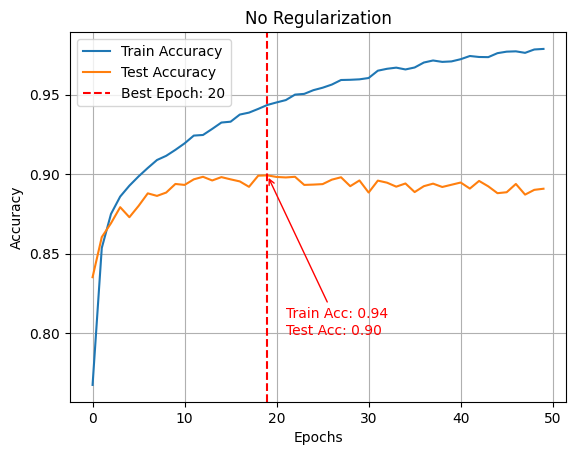

Plot saved to: ./results/No Regularization.png


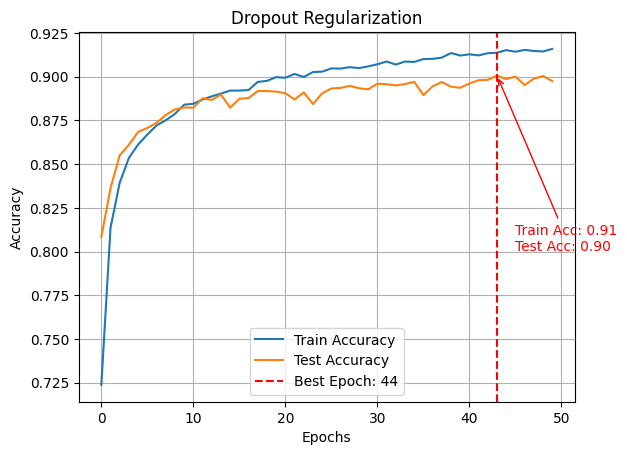

Plot saved to: ./results/Dropout Regularization.png


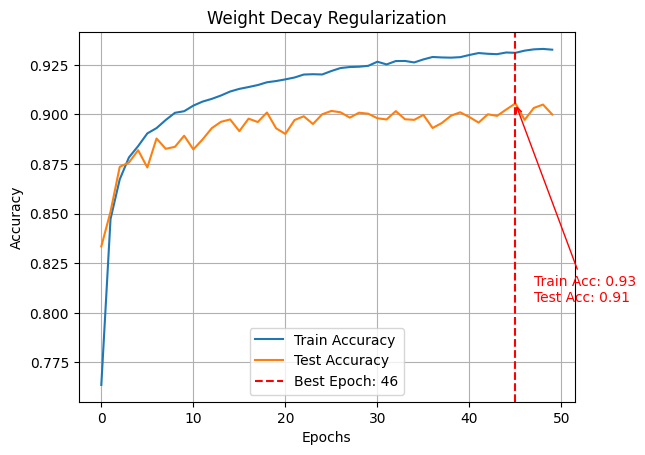

Plot saved to: ./results/Weight Decay Regularization.png


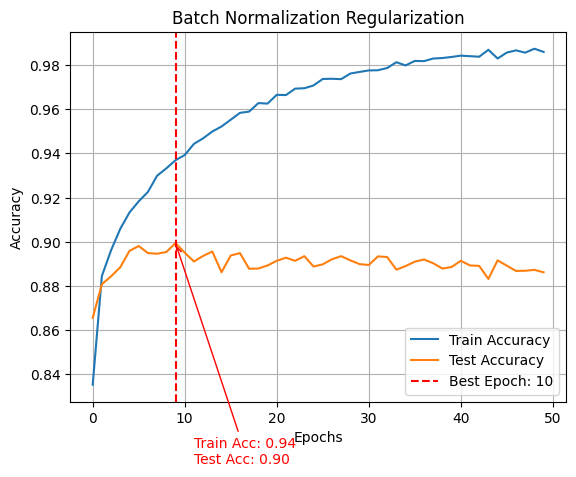

Plot saved to: ./results/Batch Normalization Regularization.png


In [12]:
# Main experiment
criterion = nn.CrossEntropyLoss()

# Without Regularization
model = LeNet5().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
train_acc, test_acc = train_and_evaluate(model, optimizer, criterion, train_loader, test_loader)
torch.save(model.state_dict(), 'LetNet5_without_reg.pth')

plot_convergence(train_acc, test_acc, "No Regularization")

# With Dropout
model_dropout = LeNet5(dropout_rate=0.5).to(device)
optimizer_dropout = optim.Adam(model_dropout.parameters(), lr=learning_rate)
train_acc_dropout, test_acc_dropout = train_and_evaluate(model_dropout, optimizer_dropout, criterion, train_loader, test_loader)
torch.save(model.state_dict(), 'LetNet5_dropout.pth')
plot_convergence(train_acc_dropout, test_acc_dropout, "Dropout Regularization")

# With Weight Decay (L2 Regularization)
model_l2 = LeNet5().to(device)
optimizer_l2 = optim.Adam(model_l2.parameters(), lr=learning_rate, weight_decay=0.001)
train_acc_l2, test_acc_l2 = train_and_evaluate(model_l2, optimizer_l2, criterion, train_loader, test_loader)
torch.save(model.state_dict(), 'LetNet5_weight_decay.pth')
plot_convergence(train_acc_l2, test_acc_l2, "Weight Decay Regularization")

# With Batch Normalization
model_bn = LeNet5(batch_norm=True).to(device)
optimizer_bn = optim.Adam(model_bn.parameters(), lr=learning_rate)
train_acc_bn, test_acc_bn = train_and_evaluate(model_bn, optimizer_bn, criterion, train_loader, test_loader)
torch.save(model.state_dict(), 'LetNet5_batch_norm.pth')
plot_convergence(train_acc_bn, test_acc_bn, "Batch Normalization Regularization")

In [13]:
import pandas as pd

# Example final accuracies (replace with your actual results)
results = {
    "Technique": [
        "No Regularization",
        "Dropout",
        "Weight Decay (L2)",
        "Batch Normalization"
    ],
    "Train Accuracy (%)": [
        train_acc[-1] * 100,
        train_acc_dropout[-1] * 100,
        train_acc_l2[-1] * 100,
        train_acc_bn[-1] * 100
    ],
    "Test Accuracy (%)": [
        test_acc[-1] * 100,
        test_acc_dropout[-1] * 100,
        test_acc_l2[-1] * 100,
        test_acc_bn[-1] * 100
    ],
}

# Create DataFrame
df_results = pd.DataFrame(results)

# Display DataFrame
display(df_results)

# Optionally save to a CSV file
df_results.to_csv("./results/lenet5_results.csv", index=False)

,Technique,Train Accuracy (%),Test Accuracy (%)
0,No Regularization,97.866667,89.08
1,Dropout,91.590000,89.75
2,Weight Decay (L2),93.266667,90.00
3,Batch Normalization,98.598333,88.62


In [ ]:
# changes shown here